In [44]:
# =========================================================
# Palm Vein Verification (RLE + MLP Embedding + Cosine)
# - Preprocessing: ROI crop + CLAHE + Gaussian blur + Sauvola adaptive threshold
# - Feature: Run-Length Encoding (RLE) on binary image
# - Model: MLP trained for identification, use embedding layer for verification
# - Verification: cosine similarity vs class templates + threshold (tuned on VER)
# - Evaluation: ROC / AUC / EER + score histograms + confusion matrix
# - Debug: show preprocessing + RLE reconstruction (approx)
# - Save: classifier, embedding model, bundle (scaler/templates/threshold/labels)
# =========================================================

import os
import glob
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pickle

from skimage import exposure
from skimage.filters import threshold_sauvola, gaussian

In [45]:
# =========================================================
# 1) RLE FEATURE
# =========================================================
def binary_runlength_vector(binary_img: np.ndarray, max_len: int = 4096) -> np.ndarray:
    """
    Convert a 2D binary image (0/1) into a 1D run-length vector [n0, n1, n0, ...].
    - Starts from first pixel.
    - If first pixel is 1, vector starts with [0, n1, ...].
    - Pads/truncates to max_len.
    - Normalizes run counts by img_size so values are ~0..1.

    NOTE: lossy representation. Intended as a baseline.
    """
    flat = binary_img.flatten().astype(np.uint8)
    if flat.size == 0:
        return np.zeros(max_len, dtype=np.float32)

    runs = []
    current = flat[0]
    count = 1

    for v in flat[1:]:
        if v == current:
            count += 1
        else:
            runs.append(count)
            current = v
            count = 1
    runs.append(count)

    # Ensure starts with zeros count
    if flat[0] == 1:
        runs = [0] + runs

    # pad / truncate
    if len(runs) < max_len:
        runs = runs + [0] * (max_len - len(runs))
    else:
        runs = runs[:max_len]

    img_size = binary_img.shape[0] * binary_img.shape[1]
    runs = (np.array(runs, dtype=np.float32) / float(img_size)).astype(np.float32)
    return runs


# =========================================================
# 2) PREPROCESSING: ROI + CLAHE + blur + Sauvola threshold
# =========================================================
def preprocess_palm_for_binary(
    arr01: np.ndarray,              # grayscale float32 in [0,1]
    roi_crop: float = 0.85,         # keep center 85% to reduce background effect
    use_clahe: bool = True,
    clahe_clip_limit: float = 0.01, # 0.005~0.03
    clahe_kernel_size=(32, 32),
    denoise_sigma: float = 0.6,     # 0.3~1.0; 0 disables
    sauvola_window_size: int = 31,  # odd 25~51
    sauvola_k: float = 0.2          # 0.1~0.4
):
    """
    Returns:
      arr_pre: enhanced grayscale in [0,1]
      binary : uint8 binary image (0/1)
    """
    arr = np.asarray(arr01, dtype=np.float32)

    # (1) ROI crop (center)
    if roi_crop is not None and 0 < roi_crop < 1.0:
        H, W = arr.shape
        ch = int(H * roi_crop)
        cw = int(W * roi_crop)
        y0 = (H - ch) // 2
        x0 = (W - cw) // 2
        arr = arr[y0:y0 + ch, x0:x0 + cw]

    # (2) CLAHE (local contrast)
    if use_clahe:
        arr = exposure.equalize_adapthist(
            arr,
            kernel_size=clahe_kernel_size,
            clip_limit=clahe_clip_limit
        ).astype(np.float32)

    # (3) light blur
    if denoise_sigma is not None and denoise_sigma > 0:
        arr = gaussian(arr, sigma=denoise_sigma, preserve_range=True).astype(np.float32)

    # (4) adaptive threshold
    th = threshold_sauvola(arr, window_size=sauvola_window_size, k=sauvola_k)
    binary = (arr >= th).astype(np.uint8)
    return arr, binary

# =========================================================
# 3) DEBUG: reconstruct approx binary from RLE
# =========================================================
def rle_vector_to_binary_image(rle_vec, img_shape=(256, 256), assume_starts_with_zero=True):
    """
    Approx reconstruct binary from normalized + padded RLE vector.
    Not exact (truncation/padding/normalization).
    """
    H, W = img_shape
    img_size = H * W

    rle_vec = np.asarray(rle_vec, dtype=np.float32).copy()
    runs = np.rint(rle_vec * img_size).astype(int)
    runs = runs[runs > 0]  # remove padding zeros

    if runs.size == 0:
        return np.zeros((H, W), dtype=np.uint8)

    flat = []
    val = 0 if assume_starts_with_zero else 1
    for L in runs:
        if L <= 0:
            continue
        flat.extend([val] * int(L))
        val = 1 - val

    flat = np.array(flat[:img_size], dtype=np.uint8)
    if flat.size < img_size:
        flat = np.pad(flat, (0, img_size - flat.size), mode="constant", constant_values=0)

    return flat.reshape(H, W)

def debug_show_preprocessing_and_rle(
    img_path,
    img_size=(256, 256),
    max_len=8192,
    pp_kwargs=None
):
    if pp_kwargs is None:
        pp_kwargs = {}

    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0

    arr_pre, binary = preprocess_palm_for_binary(arr, **pp_kwargs)
    rle = binary_runlength_vector(binary, max_len=max_len)
    recon = rle_vector_to_binary_image(rle, img_shape=binary.shape, assume_starts_with_zero=True)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.imshow(arr, cmap="gray");     plt.title("Original"); plt.axis("off")
    plt.subplot(1, 4, 2); plt.imshow(arr_pre, cmap="gray"); plt.title("After CLAHE+Blur"); plt.axis("off")
    plt.subplot(1, 4, 3); plt.imshow(binary, cmap="gray");  plt.title("Binary (Sauvola)"); plt.axis("off")
    plt.subplot(1, 4, 4); plt.imshow(recon, cmap="gray");   plt.title("Reconstructed from RLE"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# =========================================================
# 4) LOAD DATASET (RLE features)
# =========================================================
def load_palm_vein_dataset_rle(
    data_root="Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30,
    max_len=8192,
    pp_kwargs=None
):
    if pp_kwargs is None:
        pp_kwargs = {}

    X, y, label_names = [], [], []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]
    print(f"Using persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            img = Image.open(path).convert("L").resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0

            _, binary = preprocess_palm_for_binary(arr, **pp_kwargs)
            feat = binary_runlength_vector(binary, max_len=max_len)

            X.append(feat)
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y, label_names

# =========================================================
# 5) MODEL: MLP classifier with embedding layer
# =========================================================
def build_mlp_with_embedding(input_dim, num_classes, emb_dim=64):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dropout(0.2)(x)
    emb = layers.Dense(emb_dim, activation="relu", name="embedding")(x)
    x = layers.Dense(128, activation="relu")(emb)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out, name="mlp_rle_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# =========================================================
# 6) VERIFICATION: embeddings + templates + cosine (L2 norm)
# =========================================================
def l2_normalize(x, axis=1, eps=1e-12):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 1:
        return x / (np.linalg.norm(x) + eps)
    return x / (np.linalg.norm(x, axis=axis, keepdims=True) + eps)

def build_templates(embeddings, labels, num_classes):
    templates = []
    for c in range(num_classes):
        idx = np.where(labels == c)[0]
        templates.append(embeddings[idx].mean(axis=0))
    templates = np.stack(templates).astype(np.float32)
    return l2_normalize(templates, axis=1)

def build_trials(embeddings, labels, templates, num_neg=3, rng_seed=42):
    rng = np.random.default_rng(rng_seed)
    C = templates.shape[0]
    sims, gt = [], []

    for i in range(len(embeddings)):
        true_c = int(labels[i])

        # genuine
        sims.append(float(np.dot(embeddings[i], templates[true_c])))
        gt.append(1)

        # impostors
        for _ in range(num_neg):
            neg_c = int(rng.integers(0, C))
            while neg_c == true_c:
                neg_c = int(rng.integers(0, C))
            sims.append(float(np.dot(embeddings[i], templates[neg_c])))
            gt.append(0)

    return np.array(sims, dtype=np.float32), np.array(gt, dtype=np.int64)

def tune_threshold_from_trials(sims, gt, thresholds=np.linspace(-0.2, 0.99, 400)):
    best_t, best_acc = None, -1.0
    for t in thresholds:
        pred = (sims >= t).astype(int)
        acc = float(np.mean(pred == gt))
        if acc > best_acc:
            best_acc = acc
            best_t = float(t)
    return best_t, best_acc

def compute_eer(fpr, tpr, thresholds):
    fnr = 1.0 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = float((fpr[idx] + fnr[idx]) / 2.0)
    eer_thr = float(thresholds[idx])
    return eer, eer_thr

def plot_roc_and_scores(sims, gt, title_prefix=""):
    fpr, tpr, thr = roc_curve(gt, sims)
    auc = float(roc_auc_score(gt, sims))
    eer, eer_thr = compute_eer(fpr, tpr, thr)

    # ROC
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
    plt.plot([0, 1], [0, 1], "--", label="Chance")
    plt.xlabel("False Accept Rate (FAR) = FPR")
    plt.ylabel("True Accept Rate (TAR) = TPR")
    plt.title(f"{title_prefix} ROC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Score distributions
    sims_g = sims[gt == 1]
    sims_i = sims[gt == 0]
    plt.figure(figsize=(6, 4))
    plt.hist(sims_g, bins=40, alpha=0.6, label="Genuine (match)")
    plt.hist(sims_i, bins=40, alpha=0.6, label="Impostor (non-match)")
    plt.axvline(eer_thr, linestyle="--", label=f"EER thr={eer_thr:.3f}")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} Score Distributions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return auc, eer, eer_thr


# =========================================================
# 7) SINGLE-IMAGE TRUE VERIFICATION
# =========================================================
def verify_image_rle_cosine(
    embedding_model,
    scaler,
    templates,
    img_path,
    claimed_person_name,
    label_names,
    img_size=(256, 256),
    max_len=8192,
    pp_kwargs=None,
    threshold=0.0
):
    if pp_kwargs is None:
        pp_kwargs = {}

    if claimed_person_name not in label_names:
        raise ValueError(f"claimed_person_name '{claimed_person_name}' not in label_names")
    claimed_id = label_names.index(claimed_person_name)

    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0

    _, binary = preprocess_palm_for_binary(arr, **pp_kwargs)
    feat = binary_runlength_vector(binary, max_len=max_len).reshape(1, -1)
    feat_s = scaler.transform(feat)

    emb = embedding_model.predict(feat_s, verbose=0)[0]
    emb = l2_normalize(emb)  # normalize embedding

    sim = float(np.dot(emb, templates[claimed_id]))  # cosine
    is_match = (sim >= threshold)
    return is_match, claimed_person_name, sim

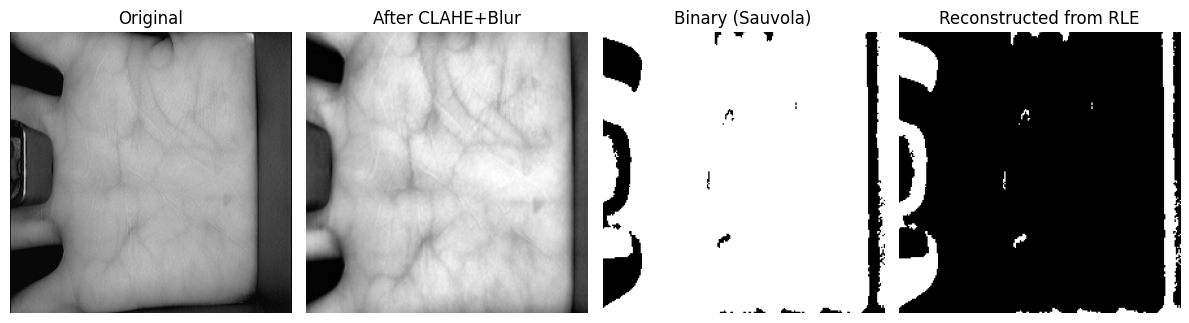

Using persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X: (360, 8192) y: (360,) #classes: 30
Train: 252 Ver: 36 Test: 72


Model: "mlp_rle_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,126,046 (8.11 MB)

 Trainable params: 2,126,046 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 - 2s - 291ms/step - accuracy: 0.0595 - loss: 3.3868 - val_accuracy: 0.0833 - val_loss: 3.2689
Epoch 2/50
8/8 - 0s - 27ms/step - accuracy: 0.4246 - loss: 2.6159 - val_accuracy: 0.1111 - val_loss: 3.0256
Epoch 3/50
8/8 - 0s - 25ms/step - accuracy: 0.6627 - loss: 1.8485 - val_accuracy: 0.2500 - val_loss: 2.7029
Epoch 4/50
8/8 - 0s - 26ms/step - accuracy: 0.8333 - loss: 1.0878 - val_accuracy: 0.3611 - val_loss: 2.3977
Epoch 5/50
8/8 - 0s - 25ms/step - accuracy: 0.9524 - loss: 0.5454 - val_accuracy: 0.3889 - val_loss: 2.1631
Epoch 6/50
8/8 - 0s - 26ms/step - accuracy: 0.9881 - loss: 0.2177 - val_accuracy: 0.4167 - val_loss: 2.0391
Epoch 7/50
8/8 - 0s - 24ms/step - accuracy: 1.0000 - loss: 0.0969 - val_accuracy: 0.4167 - val_loss: 2.0977
Epoch 8/50
8/8 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.0446 - val_accuracy: 0.4444 - val_loss: 2.0911
Epoch 9/50
8/8 - 0s - 21ms/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 0.4444 - val_loss: 2.0965
Epoch 10/50
8/8 - 0s - 25ms

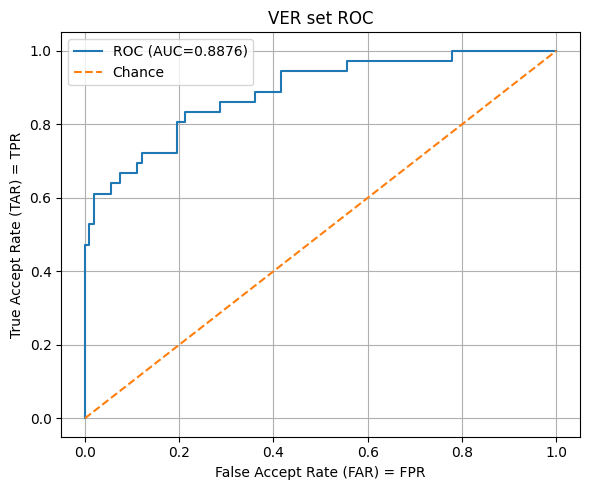

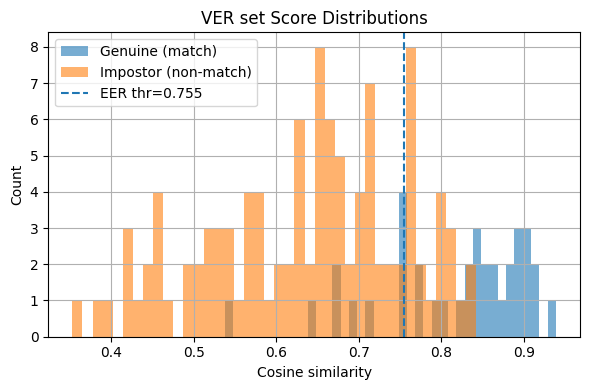

VER: AUC=0.8876, EER=0.1944, EER_thr=0.7552


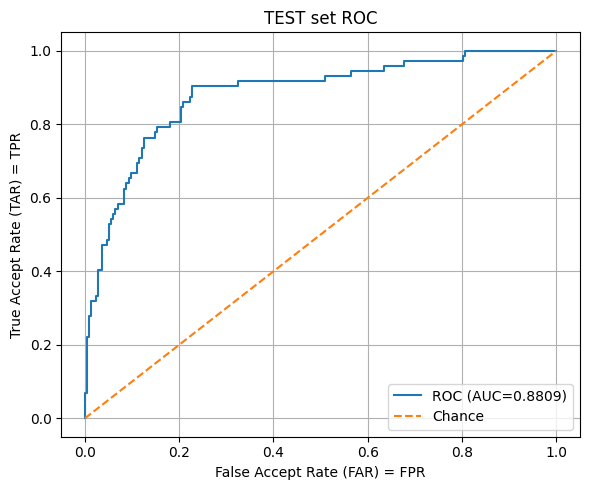

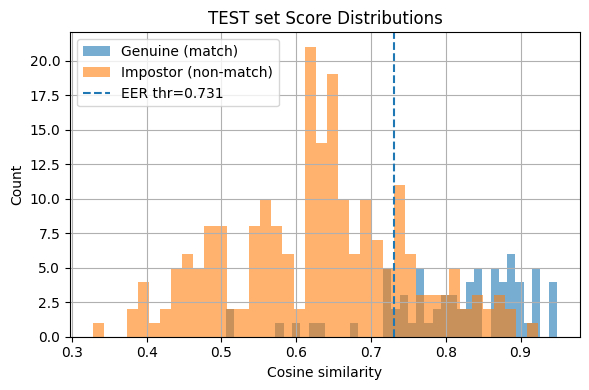

TEST: AUC=0.8809, EER=0.1991, EER_thr=0.7313


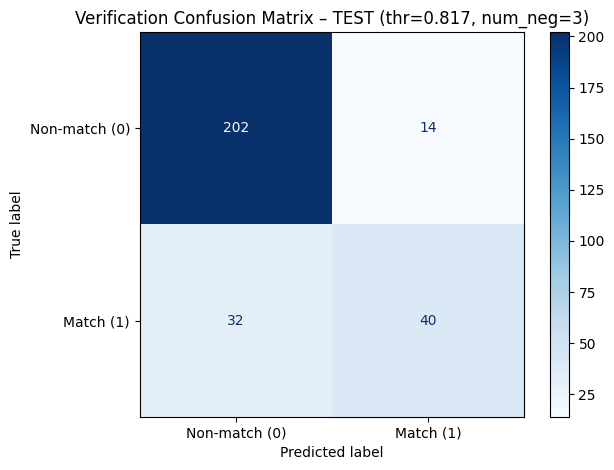


Saved: palm_mlp_rle_classifier.h5, palm_mlp_rle_embedding.h5, palm_mlp_rle_verification_bundle.pkl


In [48]:
# =========================================================
# 8) MAIN
# =========================================================
if __name__ == "__main__":
    # --------- CONFIG ----------
    DATA_ROOT = "../Multispectral Palmprint Database/NIR"
    IMG_SIZE = (256, 256)
    NUM_PERSONS = 30
    MAX_LEN = 8192

    # Preprocessing params (tune if needed)
    PP = dict(
        roi_crop=0.85,
        use_clahe=True,
        clahe_clip_limit=0.01,
        clahe_kernel_size=(32, 32),
        denoise_sigma=0.6,
        sauvola_window_size=31,
        sauvola_k=0.2
    )

    # --------- (Optional) quick debug on one image ----------
    debug_show_preprocessing_and_rle(
        img_path="../Multispectral Palmprint Database/NIR/0020/2_01.jpg",
        img_size=IMG_SIZE,
        max_len=MAX_LEN,
        pp_kwargs=PP
    )

    # --------- LOAD DATA ----------
    X, y, label_names = load_palm_vein_dataset_rle(
        data_root=DATA_ROOT,
        img_size=IMG_SIZE,
        num_persons=NUM_PERSONS,
        max_len=MAX_LEN,
        pp_kwargs=PP
    )
    num_classes = len(label_names)
    print("X:", X.shape, "y:", y.shape, "#classes:", num_classes)

    # --------- SPLIT: TRAIN / VER / TEST ----------
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=42
    )
    X_train, X_ver, y_train, y_ver = train_test_split(
        X_trainval, y_trainval, test_size=0.125, stratify=y_trainval, random_state=42
    )
    print("Train:", len(X_train), "Ver:", len(X_ver), "Test:", len(X_test))

    # --------- SCALE (fit TRAIN only) ----------
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_ver_s   = scaler.transform(X_ver)
    X_test_s  = scaler.transform(X_test)

    # --------- TRAIN MLP ----------
    mlp = build_mlp_with_embedding(input_dim=MAX_LEN, num_classes=num_classes, emb_dim=64)
    mlp.summary()

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    history = mlp.fit(
        X_train_s, y_train,
        validation_data=(X_ver_s, y_ver),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # --------- OPTIONAL: identification baseline ----------
    y_test_pred = np.argmax(mlp.predict(X_test_s, verbose=0), axis=1)
    print("\nIdentification accuracy (TEST):", accuracy_score(y_test, y_test_pred))

    # --------- EMBEDDINGS + TEMPLATES ----------
    embedding_model = keras.Model(inputs=mlp.input, outputs=mlp.get_layer("embedding").output)

    train_emb = l2_normalize(embedding_model.predict(X_train_s, verbose=0), axis=1)
    ver_emb   = l2_normalize(embedding_model.predict(X_ver_s,   verbose=0), axis=1)
    test_emb  = l2_normalize(embedding_model.predict(X_test_s,  verbose=0), axis=1)

    templates = build_templates(train_emb, y_train, num_classes)

    # --------- VER: tune threshold + plots ----------
    ver_sims, ver_gt = build_trials(ver_emb, y_ver, templates, num_neg=3, rng_seed=42)
    best_thr, ver_trial_acc = tune_threshold_from_trials(ver_sims, ver_gt)
    print(f"\nBest threshold (VER): {best_thr:.4f} | trial-acc={ver_trial_acc:.4f}")

    ver_auc, ver_eer, ver_eer_thr = plot_roc_and_scores(ver_sims, ver_gt, title_prefix="VER set")
    print(f"VER: AUC={ver_auc:.4f}, EER={ver_eer:.4f}, EER_thr={ver_eer_thr:.4f}")

    # --------- TEST: plots + confusion matrix at best_thr ----------
    test_sims, test_gt = build_trials(test_emb, y_test, templates, num_neg=3, rng_seed=123)
    test_auc, test_eer, test_eer_thr = plot_roc_and_scores(test_sims, test_gt, title_prefix="TEST set")
    print(f"TEST: AUC={test_auc:.4f}, EER={test_eer:.4f}, EER_thr={test_eer_thr:.4f}")

    test_pred = (test_sims >= best_thr).astype(int)
    cm = confusion_matrix(test_gt, test_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-match (0)", "Match (1)"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Verification Confusion Matrix – TEST (thr={best_thr:.3f}, num_neg=3)")
    plt.tight_layout()
    plt.show()

    # --------- SAVE ----------
    mlp.save("palm_mlp_rle_classifier.h5")
    embedding_model.save("palm_mlp_rle_embedding.h5")

    with open("palm_mlp_rle_verification_bundle.pkl", "wb") as f:
        pickle.dump(
            {
                "scaler_rle": scaler,
                "label_names_rle": label_names,
                "max_len": MAX_LEN,
                "templates": templates,
                "best_threshold": best_thr,
                "preprocess_params": PP,
                "img_size": IMG_SIZE,
                "num_persons": NUM_PERSONS
            },
            f
        )

    print("\nSaved: palm_mlp_rle_classifier.h5, palm_mlp_rle_embedding.h5, palm_mlp_rle_verification_bundle.pkl")

In [50]:
# =========================================================
# ---- EXAMPLE USAGE: single-image TRUE verification ----
# =========================================================
test_img_path = "../Multispectral Palmprint Database/NIR/0010/2_01.jpg"

is_match, claimed_name, similarity = verify_image_rle_cosine(
    embedding_model=embedding_model,
    scaler=scaler,
    templates=templates,
    img_path=test_img_path,
    claimed_person_name="0010",
    label_names=label_names,
    img_size=IMG_SIZE,
    max_len=MAX_LEN,
    pp_kwargs=PP,
    threshold=best_thr
)

print("\nVerification result (single image)")
print("Claimed identity:", claimed_name)
print("Cosine similarity:", similarity)
print("Match:", is_match)


Verification result (single image)
Claimed identity: 0010
Cosine similarity: 0.7993165254592896
Match: False
